In [1]:
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt
import time

In [2]:
end = time.time()*1000
start = end - 12*30*24*60*60*1000

In [3]:
query={
  "unitIds": [
    "5f0ff2f892affe3a28ebb1c2"
  ],
  "sample": "minutes",
  "start_absolute": start,
  "end_absolute": end
}

In [4]:
data = requests.post("https://data.exactspace.co/sensordata/ctperformance/ct",json=query).json()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
print(data.keys())

In [ ]:
print(data["data"][0],len(data["data"]))

In [48]:
print(data["displayorder"])

NameError: name 'data' is not defined

In [49]:
# for those using file
df = pd.read_csv("ct_data_12_month.csv")

#for those with api
#df = pd.DataFrame(data["data"])
#df.to_csv("ct_data_12_month.csv")


In [50]:

df["datetime"] = df["date"]+" "+df["year"].map(str)+" "+df["time"]
df["datetime"]=pd.to_datetime(df["datetime"])

In [52]:
# removing data from shutdown period
df = df.loc[df["load"]>10,:].reset_index(drop=True)

In [53]:
df.head()

,Unnamed: 0,load,dbttmp,coldoltmp,phr_impact,time,heat_load,design_approach,month,rh,range,year,date,wbtiltmp,effectiveness,approach,unit,datetime
0,2,55.904,32.57,0.000,16.750,05:10 PM,185.536,2.500,Jun,0.56,9.987,2022,23-Jun,25.264,49.384,10.236,HRD #4,2022-06-23 17:10:00
1,3,56.158,32.57,35.521,16.475,05:09 PM,185.536,2.459,Jun,0.56,9.987,2022,23-Jun,25.264,49.485,10.195,HRD #4,2022-06-23 17:09:00
2,4,56.271,32.57,35.500,16.201,05:08 PM,184.756,2.418,Jun,0.56,9.945,2022,23-Jun,25.264,49.480,10.154,HRD #4,2022-06-23 17:08:00
3,5,56.285,32.57,35.459,16.201,05:07 PM,184.756,2.418,Jun,0.53,9.945,2022,23-Jun,24.681,48.085,10.737,HRD #4,2022-06-23 17:07:00
4,6,56.653,32.57,35.418,16.060,05:06 PM,184.366,2.397,Jun,0.53,9.924,2022,23-Jun,24.681,48.081,10.716,HRD #4,2022-06-23 17:06:00


In [54]:
df.columns

Index(['Unnamed: 0', 'load', 'dbttmp', 'coldoltmp', 'phr_impact', 'time',
       'heat_load', 'design_approach', 'month', 'rh', 'range', 'year', 'date',
       'wbtiltmp', 'effectiveness', 'approach', 'unit', 'datetime'],
      dtype='object')

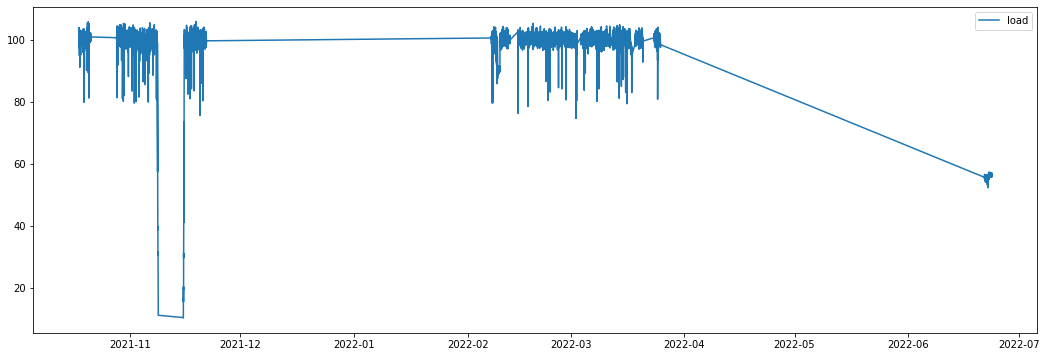

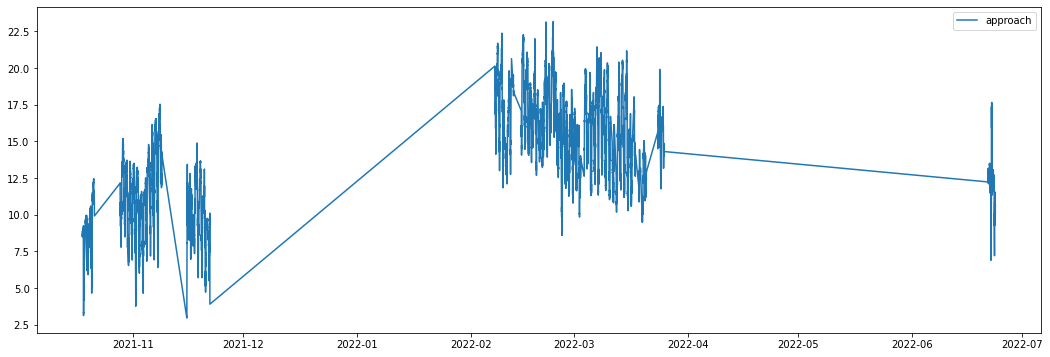

In [55]:
from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (18,6)
plt.plot(df.datetime,df.load,label="load")
plt.legend()
plt.show()

plt.plot(df.datetime,df.approach,label="approach")
plt.legend()
plt.show()

In [56]:
import numpy as np
df["load"]=df["load"].replace(0, np.nan)
df = df.loc[df["effectiveness"]<100,:]
df=df.fillna(method="ffill")

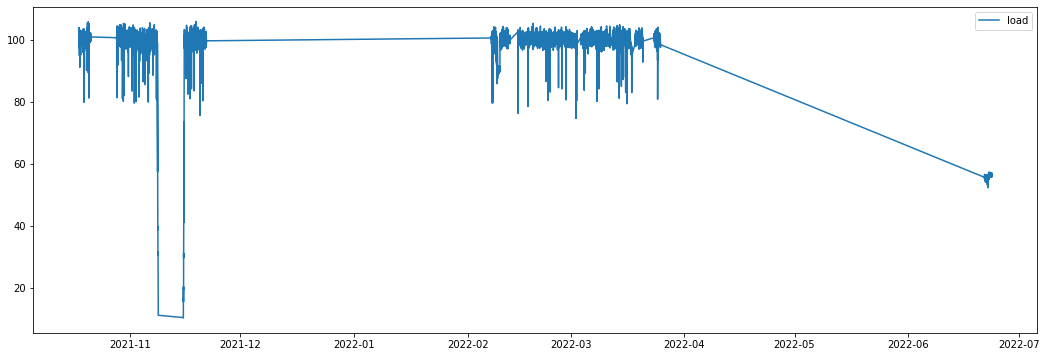

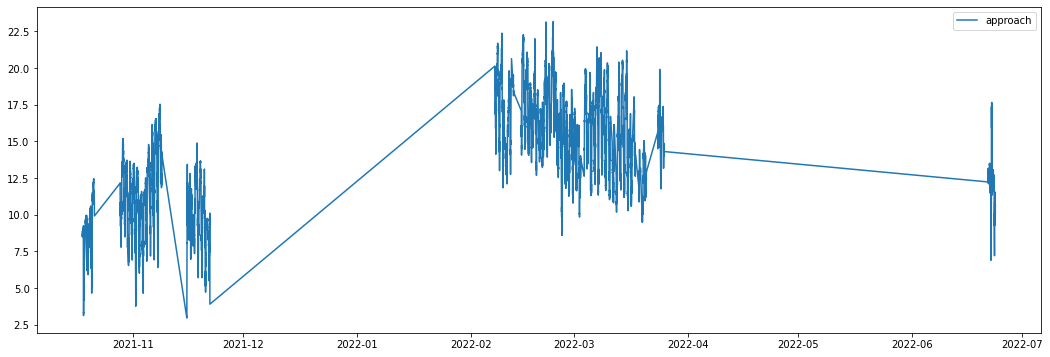

In [57]:
plt.plot(df.datetime,df.load,label="load")
plt.legend()
plt.show()
plt.plot(df.datetime,df.approach,label="approach")
plt.legend()
plt.show()

In [58]:
df=df.loc[df.effectiveness < 100,:].loc[df.effectiveness > -1,:]

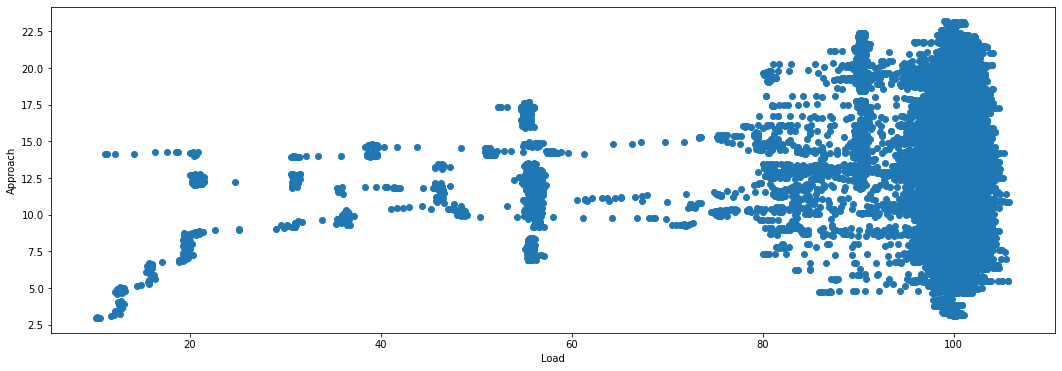

In [59]:
plt.scatter(df.load,df.approach)
plt.xlabel("Load")
plt.ylabel("Approach")
#plt.xlim(0,120)
plt.show()

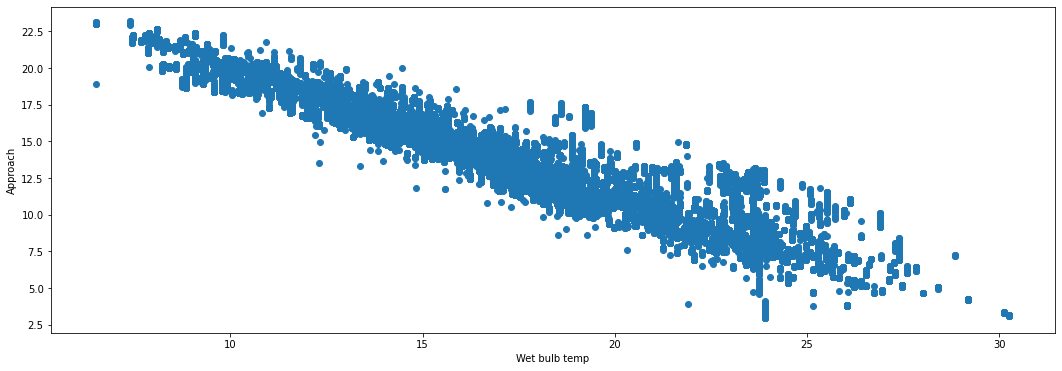

In [60]:
plt.scatter(df.wbtiltmp,df.approach)
plt.xlabel("Wet bulb temp")
plt.ylabel("Approach")
#plt.xlim(75,120)
plt.show()

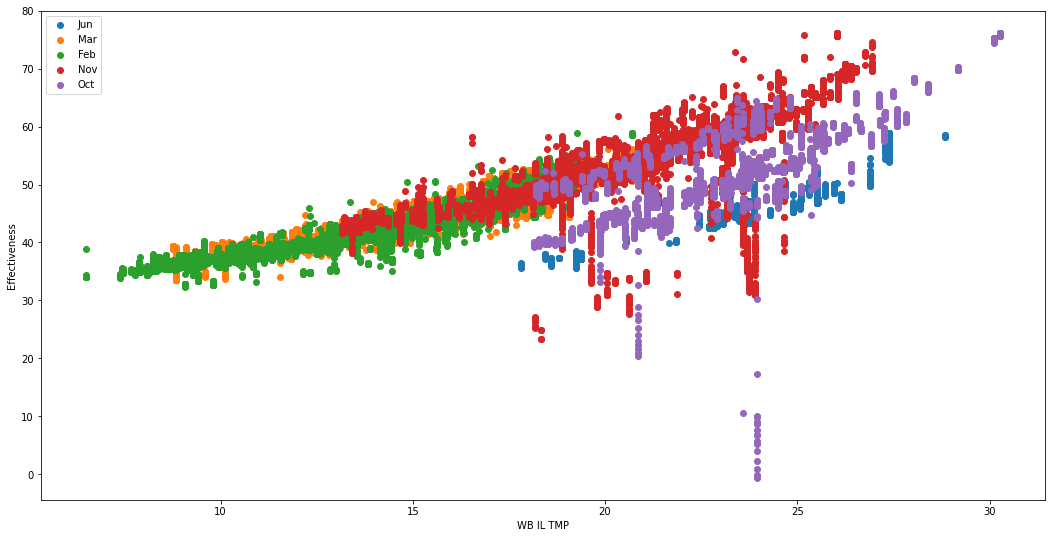

In [61]:
plt.rcParams["figure.figsize"] = (18,9)
for month in df.month.unique():
    s=df.loc[df["month"]==month,:]
    plt.scatter(s.wbtiltmp,s.effectiveness,label=month)
plt.legend()
plt.xlabel("WB IL TMP")
plt.ylabel("Effectiveness")

#plt.xlim(75,120)
plt.show()

In [62]:
# we want to predict effectiveness

# why would we want to predict effectiveness?
# capable? - past data

In [96]:
# To predict Effectiveness
# We'll few key variables
selectedVars = ['load', 'dbttmp', 'wbtiltmp','coldoltmp','effectiveness']

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [97]:
df.dropna(inplace=True,how="any")

In [102]:
# y - target variable, effectiveness
y = df.effectiveness
# x - independent variable(s)
X = df[selectedVars[0:4]]
timerange = df["datetime"]

In [103]:
X.shape,y.shape

((80297, 4), (80297,))

In [100]:
lr = LinearRegression()
rf = RandomForestRegressor()

In [68]:
# Trained linear regression - statistics - mathematics dept
lr.fit(X,y)
# Trained a new algorithm - Random forest - machine learning - computer science dept
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [69]:
# Predict using linear model
pred = lr.predict(X)
# Predict using random forest model
pred = rf.predict(X)



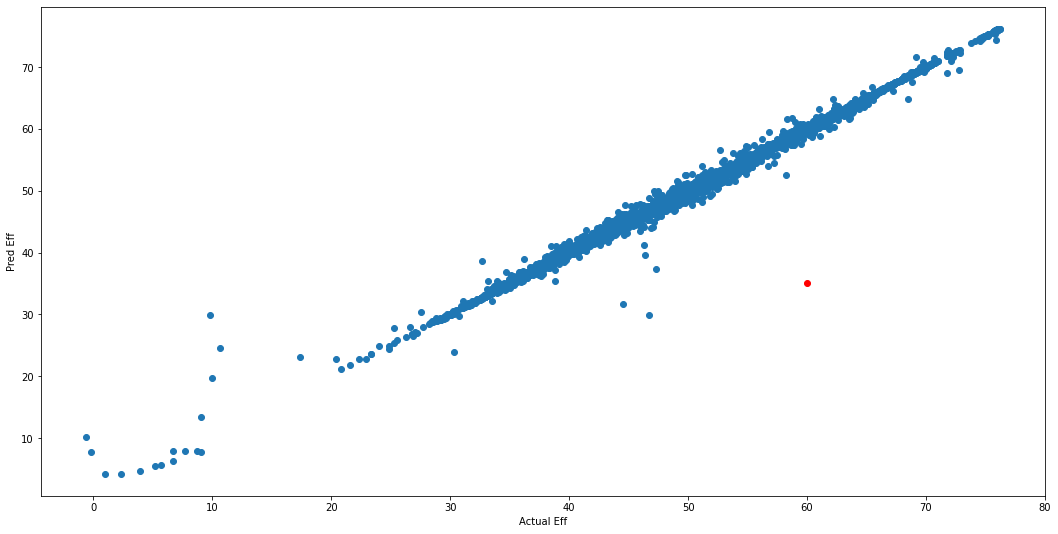

In [70]:
# Compare predicted to actuals
plt.scatter(y,pred)
plt.scatter(60,35,color="red")
plt.xlabel("Actual Eff")
plt.ylabel("Pred Eff")
plt.show()

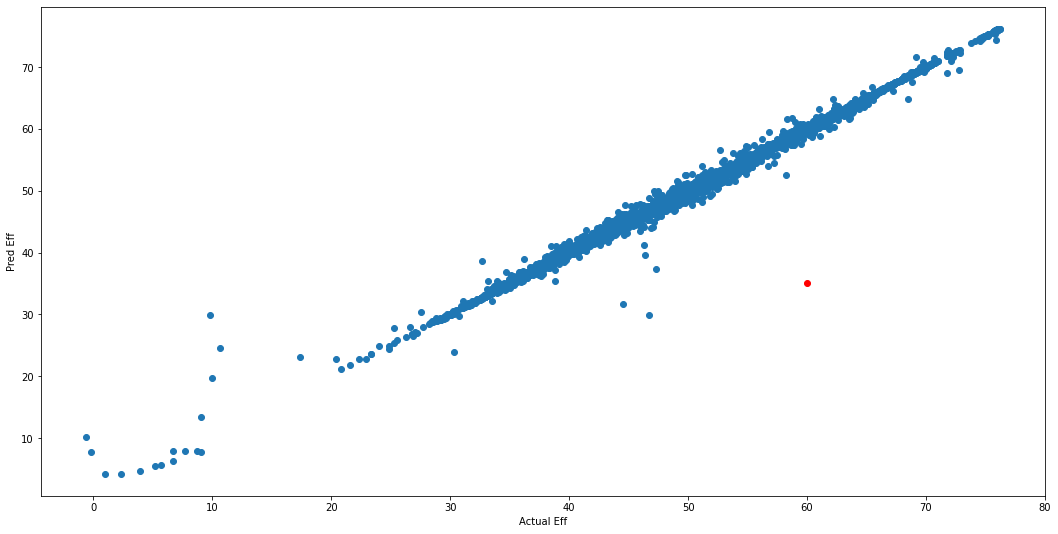

In [71]:
plt.scatter(y,pred)
plt.scatter(60,35,color="red")
plt.xlabel("Actual Eff")
plt.ylabel("Pred Eff")
plt.show()

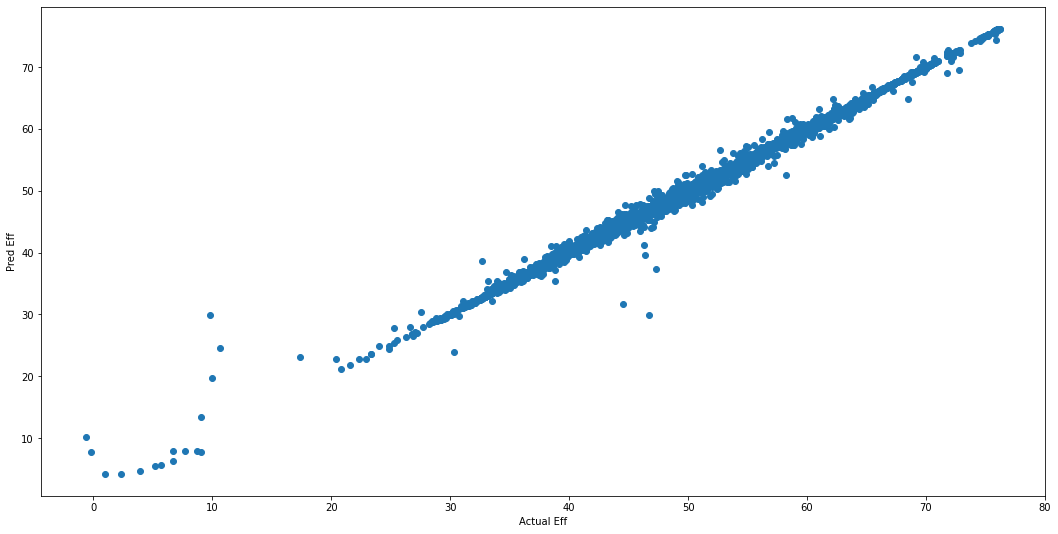

In [72]:
plt.scatter(y,pred)
plt.xlabel("Actual Eff")
plt.ylabel("Pred Eff")
plt.show()

In [73]:
# split the data into training and testing
from sklearn.model_selection import train_test_split


In [101]:
X.shape,df.shape

((80297, 4), (80297, 18))

In [104]:
## Why do we do this?
## Train(70%), test(30%)-> model has never seen
## cross validate
N=round(80297*0.7)
#x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
x_train = X.iloc[:N,:]
x_test = X.iloc[N:,:]
y_train = y[:N]
y_test = y[N:]
time_train=timerange[:N]
time_test=timerange[N:]
## sensor data
## random split, is not ideal way of sampling

In [81]:
x_train.shape, x_test.shape

((56208, 4), (24089, 4))

In [82]:
y_train.shape,y_test.shape

((56208,), (24089,))

In [83]:
# Fit models only to train data

lr.fit(x_train,y_train)
rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [84]:
pred_lr = lr.predict(x_test)
pred_rf = rf.predict(x_test)

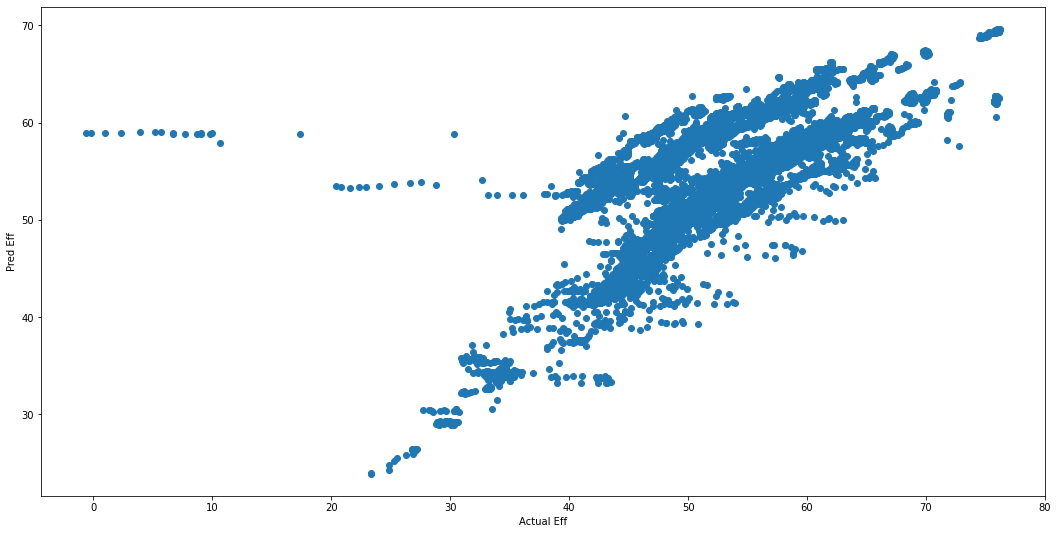

In [85]:
plt.scatter(y_test,pred_lr)
plt.xlabel("Actual Eff")
plt.ylabel("Pred Eff")
plt.show()

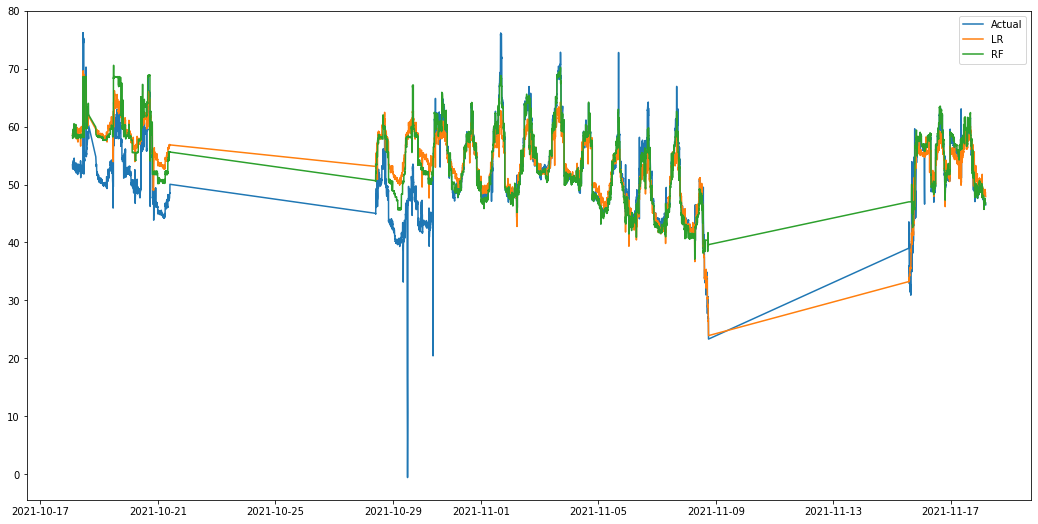

In [106]:
plt.plot(time_test,y_test.reset_index(drop=True),label="Actual")
plt.plot(time_test,pred_lr,label="LR")
plt.plot(time_test,pred_rf,label="RF")
plt.legend()
#plt.plot(x_test.load)
plt.show()

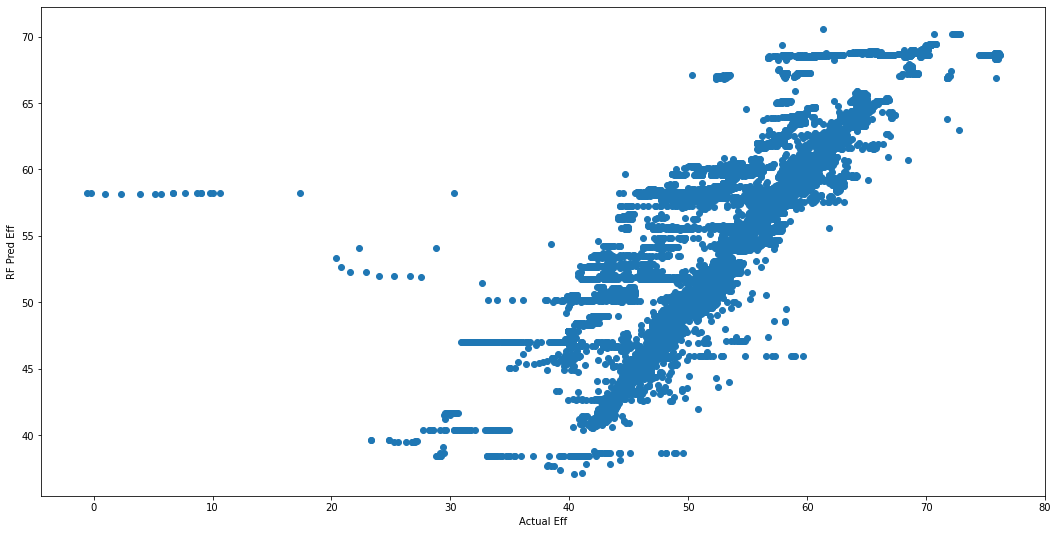

In [87]:
plt.scatter(y_test,pred_rf)
plt.xlabel("Actual Eff")
plt.ylabel("RF Pred Eff")
plt.show()

In [88]:
error = y_test - pred_rf

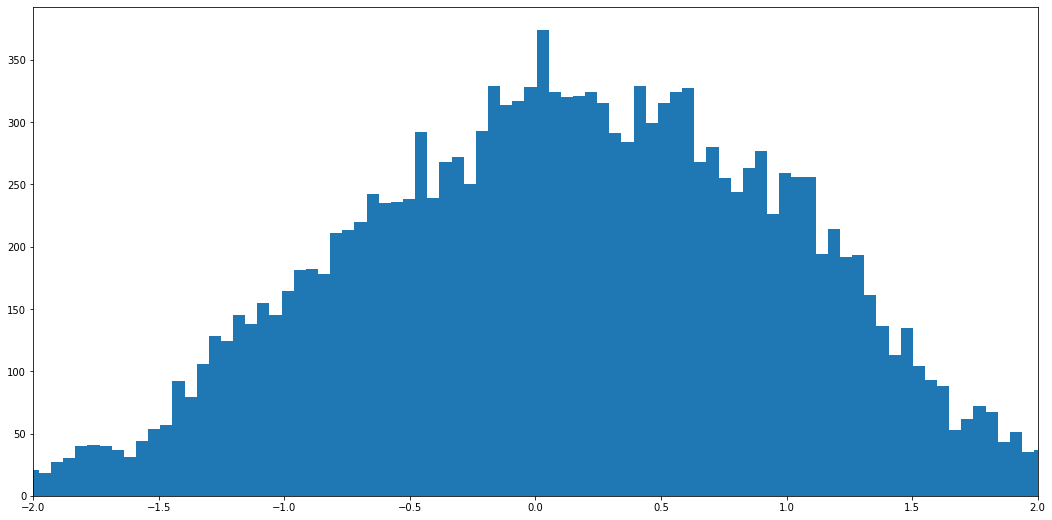

In [89]:
plt.hist(error,bins=1500)
plt.xlim(-2,2)
plt.show()